In [1]:
import numpy as np
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nv = pd.read_csv("/Users/priyanka/github/sf18_ds12_v2/projects/04-fletcher/Nevada.csv",sep="\t")
nv = nv.drop('Unnamed: 0',axis=1)


/Users/priyanka/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
nv1 = nv.copy()
nv1 = nv1.drop(nv1[(nv1.stars_y == 3) | (nv1.stars_y==3.5)].index)

In [4]:
nv1.shape

(766887, 13)

In [5]:
nv1['stars'] = np.where(nv1['stars_y'] > 2, 1, 0)
nv1_neg = nv1[nv1.stars == 0]
nv1_neg=nv1_neg.reset_index().drop('index',axis=1)
nv1_neg = nv1_neg.dropna(axis=0)



In [6]:
nv1_neg.shape

(16681, 14)

In [7]:
nv1_neg.head()

,review_id,user_id,business_id,text,name,neighborhood,city,state,latitude,longitude,stars_y,review_count,categories,stars
1,5yPsKqRQ7BmtqAvCUkKQAQ,qr9hmaIxq1z9ycgT28PpRw,Nsi49BE_XsjJ0oOXwhH8hA,This place is terrible! One star is generous ...,China Star Buffet,Eastside,Las Vegas,NV,36.1422,-115.136410,2.0,60.0,"Restaurants, Chinese",0
3,_YKZDcsZ34XzabQJXmIm-Q,bsH9WdGVrFOjMlpDBNkWIA,DVfCbJhJUDWRlUfrKzaKOA,I am from LA where there are many Sam Woos and...,Sam Woo BBQ Restaurant,Chinatown,Las Vegas,NV,36.1254,-115.195980,2.0,532.0,"Noodles, Chinese, Restaurants, Barbeque",0
4,YYHJRLJ-DWgOSF25y-9gbw,3mZFkwfa6XV0BBazRTva9w,IOwTrStIy6NinyquhBrLZQ,Overwhelming usage of ginger on practically ev...,Pick Up Stix,The Strip,Las Vegas,NV,36.0989,-115.175557,1.5,57.0,"Restaurants, Ethnic Food, Food, Imported Food,...",0
5,5Qu2S5FWyXz1pp1s55AbZg,hvZ5o9YNJJ-TVCcdT42VoQ,CHW_DPKnTqudyRaDa4vwkg,This McDonalds needs help...\n\nI used to trav...,McDonald's,Summerlin,Las Vegas,NV,36.1594,-115.320341,2.0,80.0,"Coffee & Tea, Restaurants, Food, Burgers, Fast...",0
6,eC0RSWZudPhMiswsLYckHA,C7IrOaBaxd7tYyFnb4b-lw,DVfCbJhJUDWRlUfrKzaKOA,Good food but not everything was cooked right....,Sam Woo BBQ Restaurant,Chinatown,Las Vegas,NV,36.1254,-115.195980,2.0,532.0,"Noodles, Chinese, Restaurants, Barbeque",0


Text(0.5,1,'Total count per Ratings')

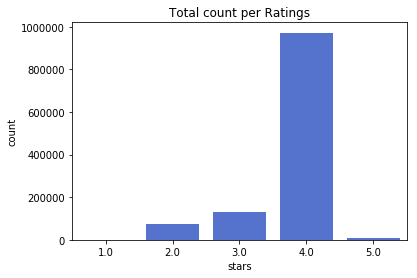

In [8]:
nv['stars_y'] = round(nv.stars_y)
sns.countplot(nv['stars_y'],color='royalblue')
plt.xlabel('stars')
plt.title('Total count per Ratings')

In [9]:
neg_text = nv1_neg['text']


In [10]:
stops = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This','yelp','http','www','com']
stop_words = text.ENGLISH_STOP_WORDS.union(stops)

In [11]:
stemmer = PorterStemmer()
corpus_neg=[' '.join([stemmer.stem(w) for w in t.split(' ')]) for t in neg_text]

In [12]:
print(corpus_neg[2])

overwhelm usag of ginger on practic everything...fri rice, noodles, orang chicken and mildli on the hous special ginger chicken.  bourbon chicken and green bean were good.


### CountVectorizer with LDA Multicore on Negative reviews

In [13]:
cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(2,2), token_pattern='[a-z][a-z]+')
cv_neg_model = cv_neg.fit_transform(neg_text).transpose()

In [14]:
neg_corpus = matutils.Sparse2Corpus(cv_neg_model)
neg_id_dict = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [15]:
lda_model_neg = gensim.models.LdaMulticore(neg_corpus, num_topics=10, id2word=neg_id_dict, passes=2, workers=2)

In [16]:
for idx, topic in lda_model_neg.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.011*"sam woo" + 0.009*"customer service" + 0.007*"tropical smoothie" + 0.005*"credit card" + 0.005*"multiple times" + 0.004*"las vegas" + 0.004*"papa john" + 0.004*"close home" + 0.004*"bbq pork" + 0.004*"didn want"
Topic: 1 Word: 0.010*"don know" + 0.004*"customer service" + 0.004*"took minutes" + 0.004*"minutes later" + 0.004*"got food" + 0.004*"read reviews" + 0.003*"hot sauce" + 0.003*"tasted like" + 0.003*"burger king" + 0.003*"got home"
Topic: 2 Word: 0.023*"ice cream" + 0.013*"customer service" + 0.011*"hot ready" + 0.006*"dairy queen" + 0.006*"fast food" + 0.005*"cheese pizza" + 0.005*"bbq sauce" + 0.005*"las vegas" + 0.004*"little caesars" + 0.004*"fried rice"
Topic: 3 Word: 0.013*"customer service" + 0.007*"burger king" + 0.006*"don know" + 0.005*"fast food" + 0.005*"las vegas" + 0.005*"panda express" + 0.004*"chicken sandwich" + 0.004*"feel like" + 0.004*"horrible horrible" + 0.004*"wait minutes"
Topic: 4 Word: 0.015*"fast food" + 0.012*"tasted like" + 0.007

### Applying NMF Algorithm with TFIDF on Negative Text reviews

In [17]:
num_features = 1000
tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words=stop_words)
tfidf = tfidf_vect.fit_transform(neg_text)
tfidf_feature_names = tfidf_vect.get_feature_names()

In [18]:
nmf_neg = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [19]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("{:11}".format("Topic %d:" %(topic_idx)), end='')
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [20]:
display_topics(nmf_neg, tfidf_feature_names, 10)



Topic 0:   said asked manager told didn got went called ordered did
Topic 1:   pizza hut delivery crust cheese ordered pizzas pepperoni ready wings
Topic 2:   food fast cold quality fresh eat better restaurant mexican overpriced
Topic 3:   chicken kfc fried spicy ordered salad wings sauce popeyes piece
Topic 4:   drive window inside cars car went fast line got mcdonald
Topic 5:   minutes wait 20 15 waiting 10 waited ready 30 line
Topic 6:   service customer horrible terrible rude slow bad poor employees customers
Topic 7:   like don people really know bad want make come think
Topic 8:   place dirty recommend avoid stars sushi sucks disgusting bar open
Topic 9:   order wrong right correct delivery placed online orders called messed
Topic 10:  buffet circus vegas buffets price selection breakfast better eat lunch
Topic 11:  smoothie tropical smoothies wrap love working juice making make cafe
Topic 12:  good pretty really nice service price thing wasn quick little
Topic 13:  chinese rice 

In [21]:
pos = nv1[nv1.stars == 1]
pos=pos.reset_index().drop('index',axis=1)
pos_text = pos.dropna(axis=0)
pos_text = pos_text['text']

In [22]:
pos_text.shape

(627360,)

### Applying TFIDF with NMF on Positive text reviews

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words=stop_words)
tfidf_pos = tfidf_vectorizer.fit_transform(pos_text)
tfidf_feature_names_pos = tfidf_vectorizer.get_feature_names()



In [24]:
nmf_pos = NMF(n_components=20, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_pos)

In [25]:
display_topics(nmf_pos, tfidf_feature_names_pos, 10)

Topic 0:   like order got didn don minutes came table said people
Topic 1:   great service atmosphere awesome drinks happy bar selection prices spot
Topic 2:   pizza crust slice cheese toppings pizzas sauce slices secret garlic
Topic 3:   place recommend try awesome eat definitely like highly looking nice
Topic 4:   burger fries burgers shake cheese truffle onion bun bacon rings
Topic 5:   good really pretty nice price little prices overall like bit
Topic 6:   chicken fried rice waffles sauce sandwich salad ordered wings waffle
Topic 7:   sushi rolls roll fish fresh ayce eat sashimi tuna quality
Topic 8:   vegas las strip restaurant favorite visit trip restaurants buffet stop
Topic 9:   steak ordered salad delicious dinner bread meal cheese sauce dessert
Topic 10:  amazing definitely recommend absolutely highly experience server thank loved wow
Topic 11:  breakfast coffee eggs pancakes sandwich toast bacon hash egg french
Topic 12:  friendly staff super nice delicious clean helpful att

### Applying CountVectorizer(bigrams) with LDA on Positive text reviews

In [26]:
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(2,2), token_pattern='[a-z][a-z]+')
cv_pos_model = cv_pos.fit_transform(pos_text).transpose()

In [27]:
pos_corpus = matutils.Sparse2Corpus(cv_pos_model)
pos_id_dict = dict((v, k) for k, v in cv_pos.vocabulary_.items())

In [28]:
lda_model_pos = gensim.models.LdaMulticore(pos_corpus, num_topics=10, id2word=pos_id_dict, passes=2, workers=2)

In [29]:
for idx, topic in lda_model_pos.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic)) 

Topic: 0 Word: 0.004*"fried rice" + 0.003*"sweet potato" + 0.003*"thai food" + 0.003*"pad thai" + 0.003*"onion rings" + 0.002*"potato fries" + 0.002*"truffle fries" + 0.001*"french fries" + 0.001*"fried egg" + 0.001*"chicken wings"
Topic: 1 Word: 0.003*"crab legs" + 0.002*"red velvet" + 0.002*"corned beef" + 0.002*"wait time" + 0.002*"worth wait" + 0.002*"long wait" + 0.002*"eggs benedict" + 0.002*"pretty good" + 0.002*"french toast" + 0.002*"wait long"
Topic: 2 Word: 0.005*"really good" + 0.003*"highly recommend" + 0.003*"staff friendly" + 0.002*"super friendly" + 0.002*"mexican food" + 0.002*"definitely come" + 0.002*"recommend place" + 0.002*"service great" + 0.002*"definitely recommend" + 0.002*"best ve"
Topic: 3 Word: 0.011*"happy hour" + 0.006*"pretty good" + 0.004*"really good" + 0.004*"carne asada" + 0.003*"fast food" + 0.002*"late night" + 0.002*"fish chips" + 0.002*"shake shack" + 0.002*"hot dog" + 0.002*"al pastor"
Topic: 4 Word: 0.005*"mac cheese" + 0.004*"ice cream" + 0.00

In [31]:
#Perplexity for Negative topics
print(lda_model_pos.log_perplexity(pos_corpus))

-11.998905077121458


In [32]:
#Perplexity for Positive topics
print(lda_model_neg.log_perplexity(neg_corpus))

-8.950070478229893
